#  Прогнозирование заказов такси

## Подготовка

In [1]:
# импорт библиотек
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import warnings
warnings.filterwarnings('ignore')

In [2]:
# чтение файла с данными и сохранение в df с использованием конструкции try-except
try:
    df = pd.read_csv('C:/Users/datasets/taxi.csv') # локальный путь
except:
    df = pd.read_csv('//datasets/taxi.csv') # серверный путь

In [3]:
# просмотр первых пяти строк 
df.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [4]:
# получение общей информации
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [5]:
# заменим тип данных datetime с object на datetime64
df['datetime'] = pd.to_datetime(df['datetime'])

In [6]:
# установим индекс таблицы равным столбцу datetime
df = df.set_index('datetime')

In [7]:
# проверим, в хронологическом ли порядке расположены даты и время
df.index.is_monotonic

True

## Анализ

Изучим наши данные.

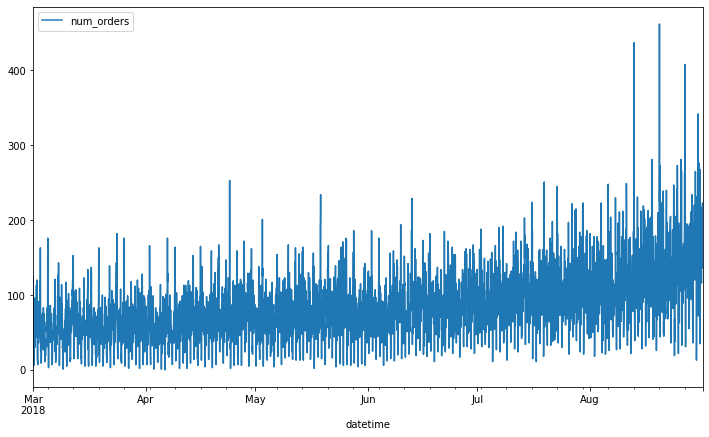

In [8]:
# выберим интервал в один час, по каждому — вычислим суммарное количество заказов такси
df = df.resample('1H').sum()
figsize = (12,7)
df.plot(figsize=figsize);

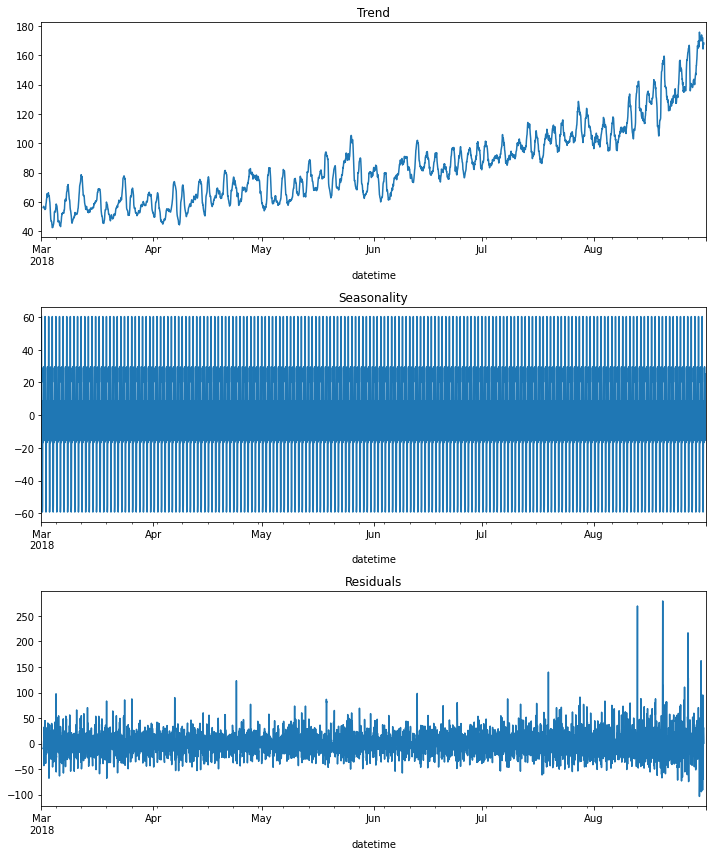

In [9]:
# разложим временной ряд на тренд и сезонную компоненту
decomposed = seasonal_decompose(df)

plt.figure(figsize=(10, 12))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

На графике тренда видно, что количество заказов такси растет. А значит временной ряд не является стационарным. 

Построим период равный неделе, чтобы исследовать сезонность.

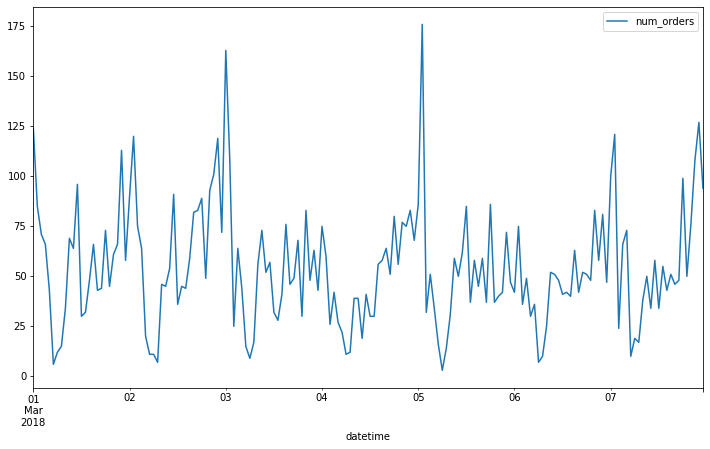

In [10]:
# график количества заказов с 01-03-2018 по 07-03-2018
df['2018-03-01':'2018-03-07'].plot(figsize=figsize);

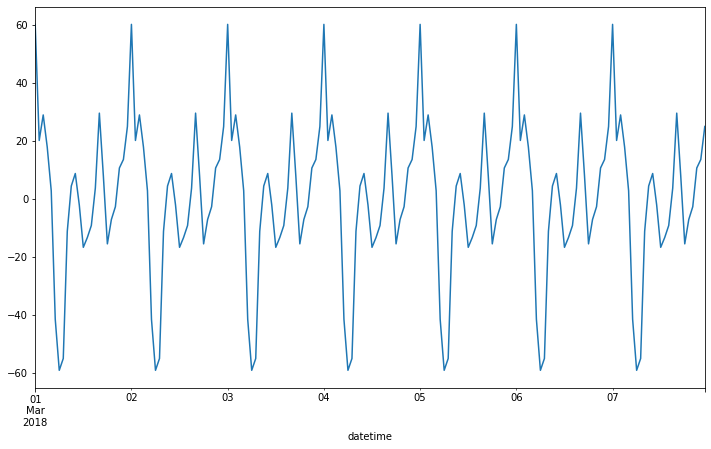

In [11]:
# построим график сезонной составляющей за неделю 
decomposed.seasonal['2018-03-01':'2018-03-07'].plot(figsize=figsize);

Из графика видно, что в ночное время количество заказов такси увеличивается и падает в утренние часы. 

<div class="alert alert-block alert-success">
<b>Успех:</b> Декомпозиция была сделана верно. Хорошо, что сезонность была визуализирована на более коротком интервале.
</div>

## Обучение

In [12]:
# напишим функцию make_features(), чтобы создать новые признаки
def make_features(df, max_lag, rolling_mean_size):
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()

Для обучения будет использовать следующие модели: LinearRegression, DecisionTreeRegressor, RandomForestRegressor, Ridge, CatBoostRegressor и LGBMRegressor.

В цикле на примере линейной регрессии подберем значения max_lag и rolling_mean_size.

In [ ]:
%%time

data = df.copy() # создадим копию df
best_rmse = 48
best_p = 0
best_q = 0
values = [i for i in range(1, 26)]
for p in values:
    for q in values:
        make_features(data, p, q)
        
        data_train, data_test = train_test_split(data, shuffle=False, test_size=0.1) # делим данные на тестовую и обучающую выборки
        data_train.dropna(inplace=True) # удаляем пропуски
        
        X_train = data_train.drop('num_orders', axis=1)
        y_train = data_train['num_orders']
        X_test = data_test.drop('num_orders', axis=1)
        y_test = data_test['num_orders']
        
        tscv = TimeSeriesSplit(n_splits=5) # используем TimeSeriesSplit вместо CV    
    
        model = LinearRegression()
        RMSE_LR = ((-cross_val_score(model, X_train, y_train, cv=tscv, scoring='neg_mean_squared_error'))**0.5).mean()
        
        if RMSE_LR < best_rmse:
            best_rmse = RMSE_LR
            best_p = p
            best_q = q
            
print('RMSE:', best_rmse, '\nmax_lag:', best_p, '\nRolling_mean_size:', best_q)

In [ ]:
# запускаем нашу функцию по найденным значениям max_lag и rolling_mean_size
make_features(df, best_p, best_q)

# разделим датасет на обучающую и тестовую выборки
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()
# создадим переменные с целевым признаком и признаками
train_features = train.drop('num_orders', axis=1)
train_target = train['num_orders']
test_features = test.drop('num_orders', axis=1)
test_target = test['num_orders']

Теперь обучим остальные модели.

In [ ]:
%%time

# DecisionTreeRegressor
param_grid = {'max_depth': range(2, 15)}
model = DecisionTreeRegressor(random_state=12345)
search = GridSearchCV(model, param_grid, cv=tscv, scoring='neg_mean_squared_error')
search.fit(train_features, train_target)

print('RMSE:', (-search.best_score_)**0.5, 'при значениях гиперпараметров:', search.best_params_)

In [ ]:
%%time

# RandomForestRegressor
param_grid = {'max_depth': range(2, 15),
              'n_estimators': range(1, 31, 10)}
model = RandomForestRegressor(random_state=12345)
search = GridSearchCV(model, param_grid, cv=tscv, scoring='neg_mean_squared_error')
search.fit(train_features, train_target)

print('RMSE: {} при значениях гиперпараметров: {}'.format((-search.best_score_)**0.5, search.best_params_))

In [ ]:
%%time

# Ridge
param_grid = {'alpha':[0.1, 1, 10, 100, 1000]}
model = Ridge()
search = GridSearchCV(model, param_grid, cv=tscv, scoring='neg_mean_squared_error')
search.fit(train_features, train_target)

print('RMSE: {} при значениях гиперпараметров: {}'.format((-search.best_score_)**0.5, search.best_params_))

In [ ]:
%%time

# CatBoostRegressor
param_grid = {'learning_rate': [x/10 for x in range(1, 6)]}
model = CatBoostRegressor(random_state=12345, verbose=False)
search = GridSearchCV(model, param_grid, cv=tscv, scoring='neg_mean_squared_error')
search.fit(train_features, train_target)

print('RMSE: {} при значениях гиперпараметров: {}'.format((-search.best_score_)**0.5, search.best_params_))

In [ ]:
%%time

# LGBMRegressor
param_grid = {'learning_rate': [x/10 for x in range(1, 6)]}

model = LGBMRegressor(random_state=12345)
search = GridSearchCV(model, param_grid, cv=tscv, scoring='neg_mean_squared_error')
search.fit(train_features, train_target)

print('RMSE: {} при значениях гиперпараметров: {}'.format((-search.best_score_)**0.5, search.best_params_))

Протетируем модели и сравним предсказание с тестовыми данными.

## Тестирование

In [ ]:
%%time

# LinearRegression
model = LinearRegression()
model.fit(train_features, train_target)
target_predict = model.predict(test_features)
print('RMSE:', mean_squared_error(test_target, target_predict) ** 0.5)

plt.figure(figsize=figsize)
plt.plot(test_target.index, 
         test_target, 
         'b-', 
         test_target.index, 
         target_predict,
         'r-');

In [ ]:
%%time

# DecisionTreeRegressor
model = DecisionTreeRegressor(random_state=12345, max_depth=3)
model.fit(train_features, train_target)
target_predict = model.predict(test_features)
print('RMSE:', mean_squared_error(test_target, target_predict) ** 0.5)

plt.figure(figsize=figsize)
plt.plot(test_target.index, 
         test_target, 
         'b-', 
         test_target.index, 
         target_predict,
         'r-');

In [ ]:
%%time

# RandomForestRegressor
model = RandomForestRegressor(random_state=12345, max_depth=13, n_estimators=21)
model.fit(train_features, train_target)
target_predict = model.predict(test_features)
print('RMSE:', mean_squared_error(test_target, target_predict) ** 0.5)

plt.figure(figsize=figsize)
plt.plot(test_target.index, 
         test_target, 
         'b-', 
         test_target.index, 
         target_predict,
         'r-');

In [ ]:
%%time

# Ridge
model = Ridge(alpha=0.1)
model.fit(train_features, train_target)
target_predict = model.predict(test_features)
print('RMSE:', mean_squared_error(test_target, target_predict) ** 0.5)

plt.figure(figsize=figsize)
plt.plot(test_target.index, 
         test_target, 
         'b-', 
         test_target.index, 
         target_predict,
         'r-');

In [ ]:
%%time

# CatBoostRegressor
model = CatBoostRegressor(learning_rate=0.1, random_state=12345, verbose=False)
model.fit(train_features, train_target)
target_predict = model.predict(test_features)
print('RMSE:', mean_squared_error(test_target, target_predict) ** 0.5)

plt.figure(figsize=figsize)
plt.plot(test_target.index, 
         test_target, 
         'b-', 
         test_target.index, 
         target_predict,
         'r-');

In [ ]:
%%time

# LGBMRegressor
model = LGBMRegressor(learning_rate=0.1, random_state=12345)
model.fit(train_features, train_target)
target_predict = model.predict(test_features)
print('RMSE:', mean_squared_error(test_target, target_predict) ** 0.5)

plt.figure(figsize=figsize)
plt.plot(test_target.index, 
         test_target, 
         'b-', 
         test_target.index, 
         target_predict,
         'r-');

In [ ]:
# создание таблицы для сравнения полученных результатов
X = [[27.00, 45.67],
     [31.21, 56.35],
     [26.54, 44.72],
     [27.24, 45.67],
     [25.27, 41.25],
     [, 42.47]]
models = ['Linear', 'Tree', 'Forest', 'Ridge', 'Catboost', 'LGBM']

pd.DataFrame(data=X, index=models, columns=['RMSE_train', 'RMSE_test'])

Таким образом, лучшее значение показала модель CatBoostRegressor.